In [2]:
from neural_network import *

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from scipy.stats import norm

In [3]:
input_size1 = 5
output_size1 = 2
input_size2 = 3
output_size2 = 2

filename = 'model.pt'

NN = Neural_network(input_size1,output_size1,input_size2,output_size2)

NN.load(filename)
NN.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
pars_base = {'c':8.3, 'phi':31.6, 'gamma':15, 'c_cov':30, 'phi_cov':20, 'gamma_cov':7, 'H':10}
costs_base = {'operation':5, 'escavation':13, 'failure1':20, 'failure2':10000, 'expansion':1.2}

mult_range = np.linspace(0.5,2.0,151)

In [5]:
def get_optimum(pars,costs,deltaHV=0.0001):

    HVs = np.arange(0.5,4,deltaHV)

    n_cases = len(HVs)

    data_in = np.tile(np.array([pars['c'],pars['phi'],pars['gamma'],0,pars['H'],pars['c_cov'],pars['phi_cov'],pars['gamma_cov']]),(n_cases,1))
    data_in[:,3] = HVs

    df = NN.run_model(data_in,costs=costs)

    M = df.to_numpy()

    ind_min = np.argmin(M[:,15])

    HV = M[ind_min,3]
    FS = M[ind_min,9]
    beta = M[ind_min,11]
    PF = M[ind_min,12]
    c_init = M[ind_min,13]
    c_fail = M[ind_min,14]
    c_total = M[ind_min,15]

    return HV, FS, PF, c_init, c_fail, c_total, beta


In [6]:
def sweep_var(var,val_range,pars_base,costs_base):
    #pars_base = {'c':8.3, 'phi':31.6, 'gamma':15, 'c_cov':30, 'phi_cov':20, 'gamma_cov':7, 'H':10}
    #costs_base = {'operation':5, 'escavation':13, 'failure1':20, 'failure2':10000, 'expansion':1.2}

    pars = pars_base.copy()
    costs = costs_base.copy()

    n_cases = len(val_range)
    HV = np.zeros(n_cases); FS = np.zeros(n_cases); PF = np.zeros(n_cases); beta = np.zeros(n_cases)
    c_init = np.zeros(n_cases); c_fail = np.zeros(n_cases); c_total = np.zeros(n_cases)

    for i, val in enumerate(val_range):
        if var.startswith(('c_')):
            costs[var[2:]]=val
        else:
            pars[var]=val

        HV[i], FS[i], PF[i], c_init[i], c_fail[i], c_total[i], beta[i] = get_optimum(pars,costs)

    return HV, FS, PF, c_init, c_fail, c_total, beta

In [7]:
var = 'phi'

ranges = {'c': [5, 30],
            'phi': [20, 35],
            'gamma': [15, 20],
            'c_cov': [10, 50],
            'phi_cov': [10, 30],
            'gamma_cov': [3, 11]}

val_range = np.linspace(ranges[var][0],ranges[var][1],151)


HV, FS, PF, c_init, c_fail, c_total, beta = sweep_var(var,val_range,pars_base,costs_base)

In [8]:
pars_base

{'c': 8.3,
 'phi': 31.6,
 'gamma': 15,
 'c_cov': 30,
 'phi_cov': 20,
 'gamma_cov': 7,
 'H': 10}

Text(0, 0.5, 'Costs')

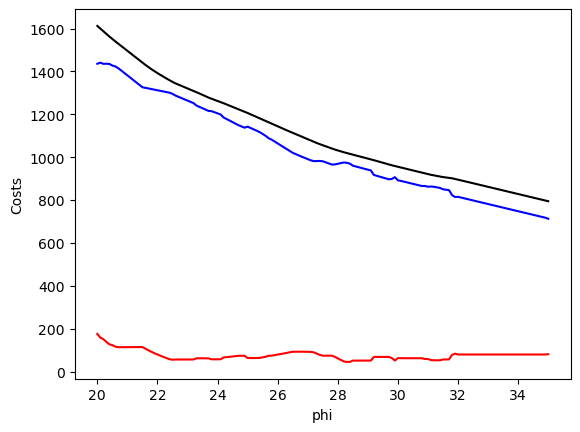

In [9]:
plt.plot(val_range,c_init,'b')
plt.plot(val_range,c_fail,'r')
plt.plot(val_range,c_total,'k')

plt.xlabel(var)
plt.ylabel('Costs')


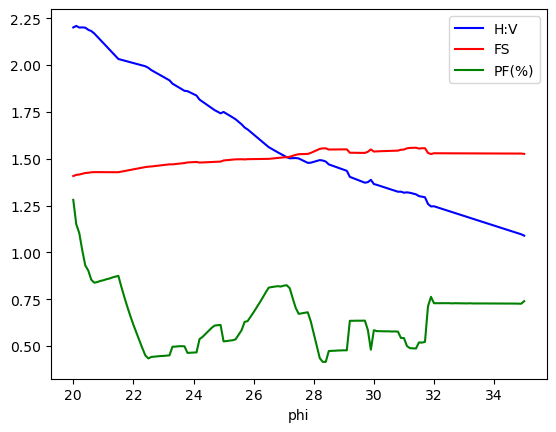

In [10]:
plt.plot(val_range,HV,'b',label='H:V')
plt.plot(val_range,FS,'r', label='FS')
plt.plot(val_range,100*PF,'g',label='PF(%)')

plt.xlabel(var)
plt.legend()

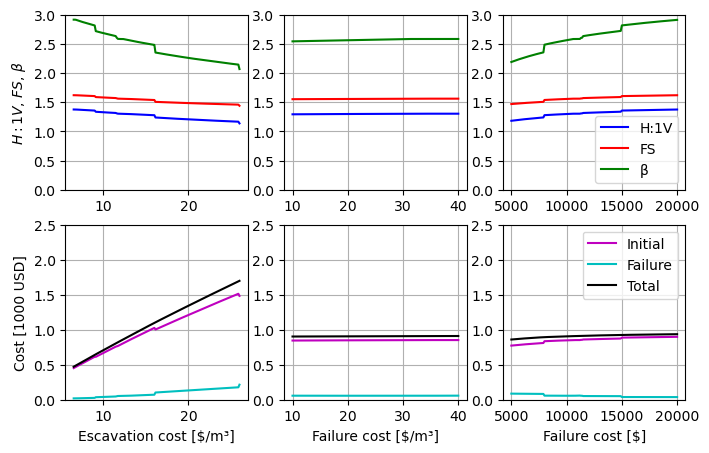

In [11]:
vars = ['c_escavation','c_failure1','c_failure2']
var_names = ['Escavation cost [$/m³]', 'Failure cost [$/m³]', 'Failure cost [$]']

plt.figure(figsize=(8, 5))

for i in range(0,3):

    var = vars[i]

    if var.startswith(('c_')):
        val_range=costs_base[var[2:]] * mult_range
    else:
        val_range = pars_base[var] * mult_range

    HV, FS, PF, c_init, c_fail, c_total, beta = sweep_var(var,val_range,pars_base,costs_base)

    plt.subplot(2,3,i+1)
    plt.plot(val_range,HV,'b',label='H:1V')
    plt.plot(val_range,FS,'r', label='FS')
    plt.plot(val_range,beta,'g',label='β')

    if i == 2:
        plt.legend()

    plt.grid(True)

    if i == 0:
        plt.ylabel('$H:1V$, $FS$, $β$')
    plt.ylim((0,3))

    plt.subplot(2,3,i+4)
    plt.plot(val_range,c_init/1000,'m',label='Initial')
    plt.plot(val_range,c_fail/1000,'c',label='Failure')
    plt.plot(val_range,c_total/1000,'k',label='Total')

    plt.xlabel(var_names[i])
    if i == 2:
        plt.legend()

    plt.grid(True)

    if i == 0:
        plt.ylabel('Cost [1000 USD]')
    plt.ylim((0,2.5))

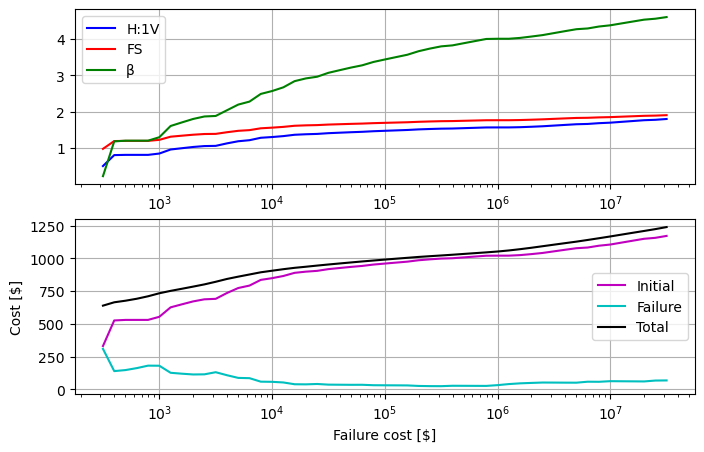

In [18]:

plt.figure(figsize=(8, 5))

var = 'c_failure2'
var_name = 'Failure cost [$]'

val_range= [10.0**i for i in np.arange(2.5,7.6,0.1)]

pars_base = {'c':8.3, 'phi':31.6, 'gamma':15, 'c_cov':30, 'phi_cov':20, 'gamma_cov':7, 'H':10}

HV, FS, PF, c_init, c_fail, c_total, beta = sweep_var(var,val_range,pars_base,costs_base)

plt.subplot(2,1,1)
plt.plot(val_range,HV,'b',label='H:1V')
plt.plot(val_range,FS,'r', label='FS')
plt.plot(val_range,beta,'g',label='β')

if i == 2:
    plt.legend()

plt.grid(True)

if i == 0:
    plt.ylabel('$H:1V$, $FS$, $β$')
#plt.ylim((0,3))
plt.xscale('log')
#plt.yscale('log')

plt.subplot(2,1,2)
plt.plot(val_range,c_init,'m',label='Initial')
plt.plot(val_range,c_fail,'c',label='Failure')
plt.plot(val_range,c_total,'k',label='Total')

plt.xlabel(var_name)
if i == 2:
    plt.legend()

plt.grid(True)

plt.ylabel('Cost [$]')
plt.xscale('log')
#plt.yscale('log')

In [19]:
val_range= [100, 1000, 10000, 100000, 1000000, 10000000]
H_range = [10, 20, 30]

pars_base = {'c':8.3, 'phi':31.6, 'gamma':15, 'c_cov':30, 'phi_cov':20, 'gamma_cov':7, 'H':10}

HV, FS, PF, c_init, c_fail, c_total, beta = sweep_var(var,val_range,pars_base,costs_base)

import pandas as pd

H_range = [10, 20, 30]  # Define the values of H for the sweep
val_range= [100, 1000, 10000, 100000, 1000000, 10000000]

results = []  # Store the results for each H value

for H in H_range:
    pars = pars_base
    pars['H'] = H
    HV, FS, PF, c_init, c_fail, c_total, beta = sweep_var(var, val_range, pars, costs_base)
    results.append(pd.DataFrame({'Cost':val_range, 'HV': HV, 'FS': FS, 'PF': PF, 'beta': beta, 'c_init': c_init, 'c_fail': c_fail, 'c_total': c_total}))

results


[       Cost      HV        FS        PF      beta    c_init      c_fail  \
 0       100  0.5000  0.972958  0.412311  0.221605   330.000  219.605994   
 1      1000  0.8439  1.220821  0.098009  1.292980   553.535  179.814010   
 2     10000  1.2979  1.556205  0.005187  2.563129   848.635   56.871948   
 3    100000  1.4695  1.688317  0.000301  3.430969   960.175   30.366105   
 4   1000000  1.5626  1.760681  0.000031  4.001456  1020.690   31.513687   
 5  10000000  1.6930  1.845829  0.000006  4.371198  1105.450   61.792107   
 
        c_total  
 0   549.605994  
 1   733.349010  
 2   905.506948  
 3   990.541105  
 4  1052.203687  
 5  1167.242107  ,
        Cost      HV        FS        PF      beta   c_init       c_fail  \
 0       100  0.5000  0.838106  0.734245 -0.625703  1305.00   737.527428   
 1      1000  0.5000  0.838106  0.734245 -0.625703  1305.00  1398.347908   
 2     10000  1.2627  1.345833  0.030589  1.872208  3288.02   413.377514   
 3    100000  1.5754  1.569315  0.0

In [14]:
results[2]

,Cost,HV,FS,PF,beta,c_init,c_fail,c_total
0,100,0.5000,0.802217,0.862795,-1.092962,2930.000,1416.848202,4346.848202
1,1000,0.5000,0.802217,0.862795,-1.092962,2930.000,2193.363445,5123.363445
2,10000,1.3516,1.373281,0.055044,1.597797,7911.860,983.221938,8895.081938
3,100000,1.6283,1.571270,0.005790,2.524698,9530.555,650.585501,10181.140501
4,1000000,1.9100,1.696137,0.001042,3.077887,11178.500,1067.955358,12246.455358
5,10000000,2.4303,1.926825,0.000104,3.708931,14222.255,1044.851133,15267.106133


In [22]:
pars_base['H'] = 10

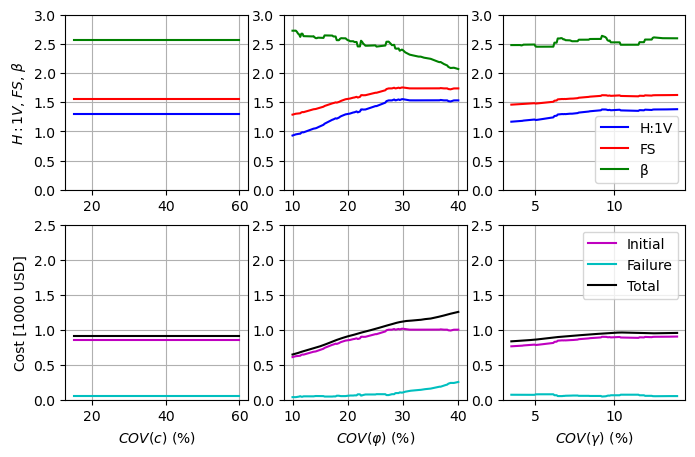

In [24]:
vars = ['c_cov','phi_cov','gamma_cov']
var_names = ['$COV$($c$) (%)', '$COV$($φ$) (%)', '$COV$($γ$) (%)']

plt.figure(figsize=(8, 5))

for i in range(0,3):

    var = vars[i]

    if var.startswith(('c_')) and not var == 'c_cov':
        val_range=costs_base[var[2:]] * mult_range
    else:
        val_range = pars_base[var] * mult_range

    HV, FS, PF, c_init, c_fail, c_total, beta = sweep_var(var,val_range,pars_base,costs_base)

    plt.subplot(2,3,i+1)
    plt.plot(val_range,HV,'b',label='H:1V')
    plt.plot(val_range,FS,'r', label='FS')
    plt.plot(val_range,beta,'g',label='β')

    if i == 2:
        plt.legend()

    plt.grid(True)

    if i == 0:
        plt.ylabel('$H:1V$, $FS$, $β$')
    plt.ylim((0,3))

    plt.subplot(2,3,i+4)
    plt.plot(val_range,c_init/1000,'m',label='Initial')
    plt.plot(val_range,c_fail/1000,'c',label='Failure')
    plt.plot(val_range,c_total/1000,'k',label='Total')

    plt.xlabel(var_names[i])
    if i == 2:
        plt.legend()

    plt.grid(True)

    if i == 0:
        plt.ylabel('Cost [1000 USD]')
    plt.ylim((0,2.5))